Лабораторная работа №1
======================

Конфигурация нейронной сети:

1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
3. Скрытый слой содержит `s` нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов `s` - 300.
    - Количество эпох – 20.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import math
from array import array
from pathlib import Path
from time import time
%matplotlib inline

## Подготовка данных

### Загрузка данных
Входные данные: датасет `MNIST-784` (https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath : str, training_labels_filepath : str, test_images_filepath : str, test_labels_filepath : str):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    @staticmethod
    def read_labels_from_file(file_path: str):
        with open(file_path, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            assert magic == 2049
            return np.frombuffer(file.read(), dtype=np.uint8), size

    @staticmethod
    def read_images_data_from_file(file_path: str):
        with open(file_path, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            assert magic == 2051
            return np.frombuffer(file.read(), dtype=np.uint8), rows, cols

    def read_images_labels(self, images_filepath : str, labels_filepath : str):
        labels, size = self.read_labels_from_file(file_path=labels_filepath)
        image_data, rows, cols = self.read_images_data_from_file(file_path=images_filepath)

        images = [np.array(image_data[(i * rows * cols):((i + 1) * rows * cols)]) for i in range(size)]
        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)

In [3]:
input_path = Path("/work") / "mnist"
training_images_filepath = input_path / "train-images-idx3-ubyte/train-images-idx3-ubyte"
training_labels_filepath = input_path / "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_filepath = input_path / "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_filepath = input_path / "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = loader.load_data()

### Проверка загрузки данных

Размеры тестовых и тренировочных выборок

In [4]:
print(f"Train datasize: X_train={len(X_train)}, y_train={len(y_train)}")
print(f"Test datasize: X_test={len(X_test)} y_test={len(y_test)}")
print(f"X_train sample shape: {X_train[0].shape}")

Train datasize: X_train=60000, y_train=60000
Test datasize: X_test=10000 y_test=10000
X_train sample shape: (784,)


Визуализация случайных 12 изображений в тренировочоной выборке

In [5]:
def show_images(images: list[np.ndarray], title_texts: list[str], cols: int):
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for image, title_text in zip(images, title_texts):
        plt.subplot(rows, cols, index)
        plt.imshow(image.reshape(28, 28), cmap="gray")
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)
        index += 1

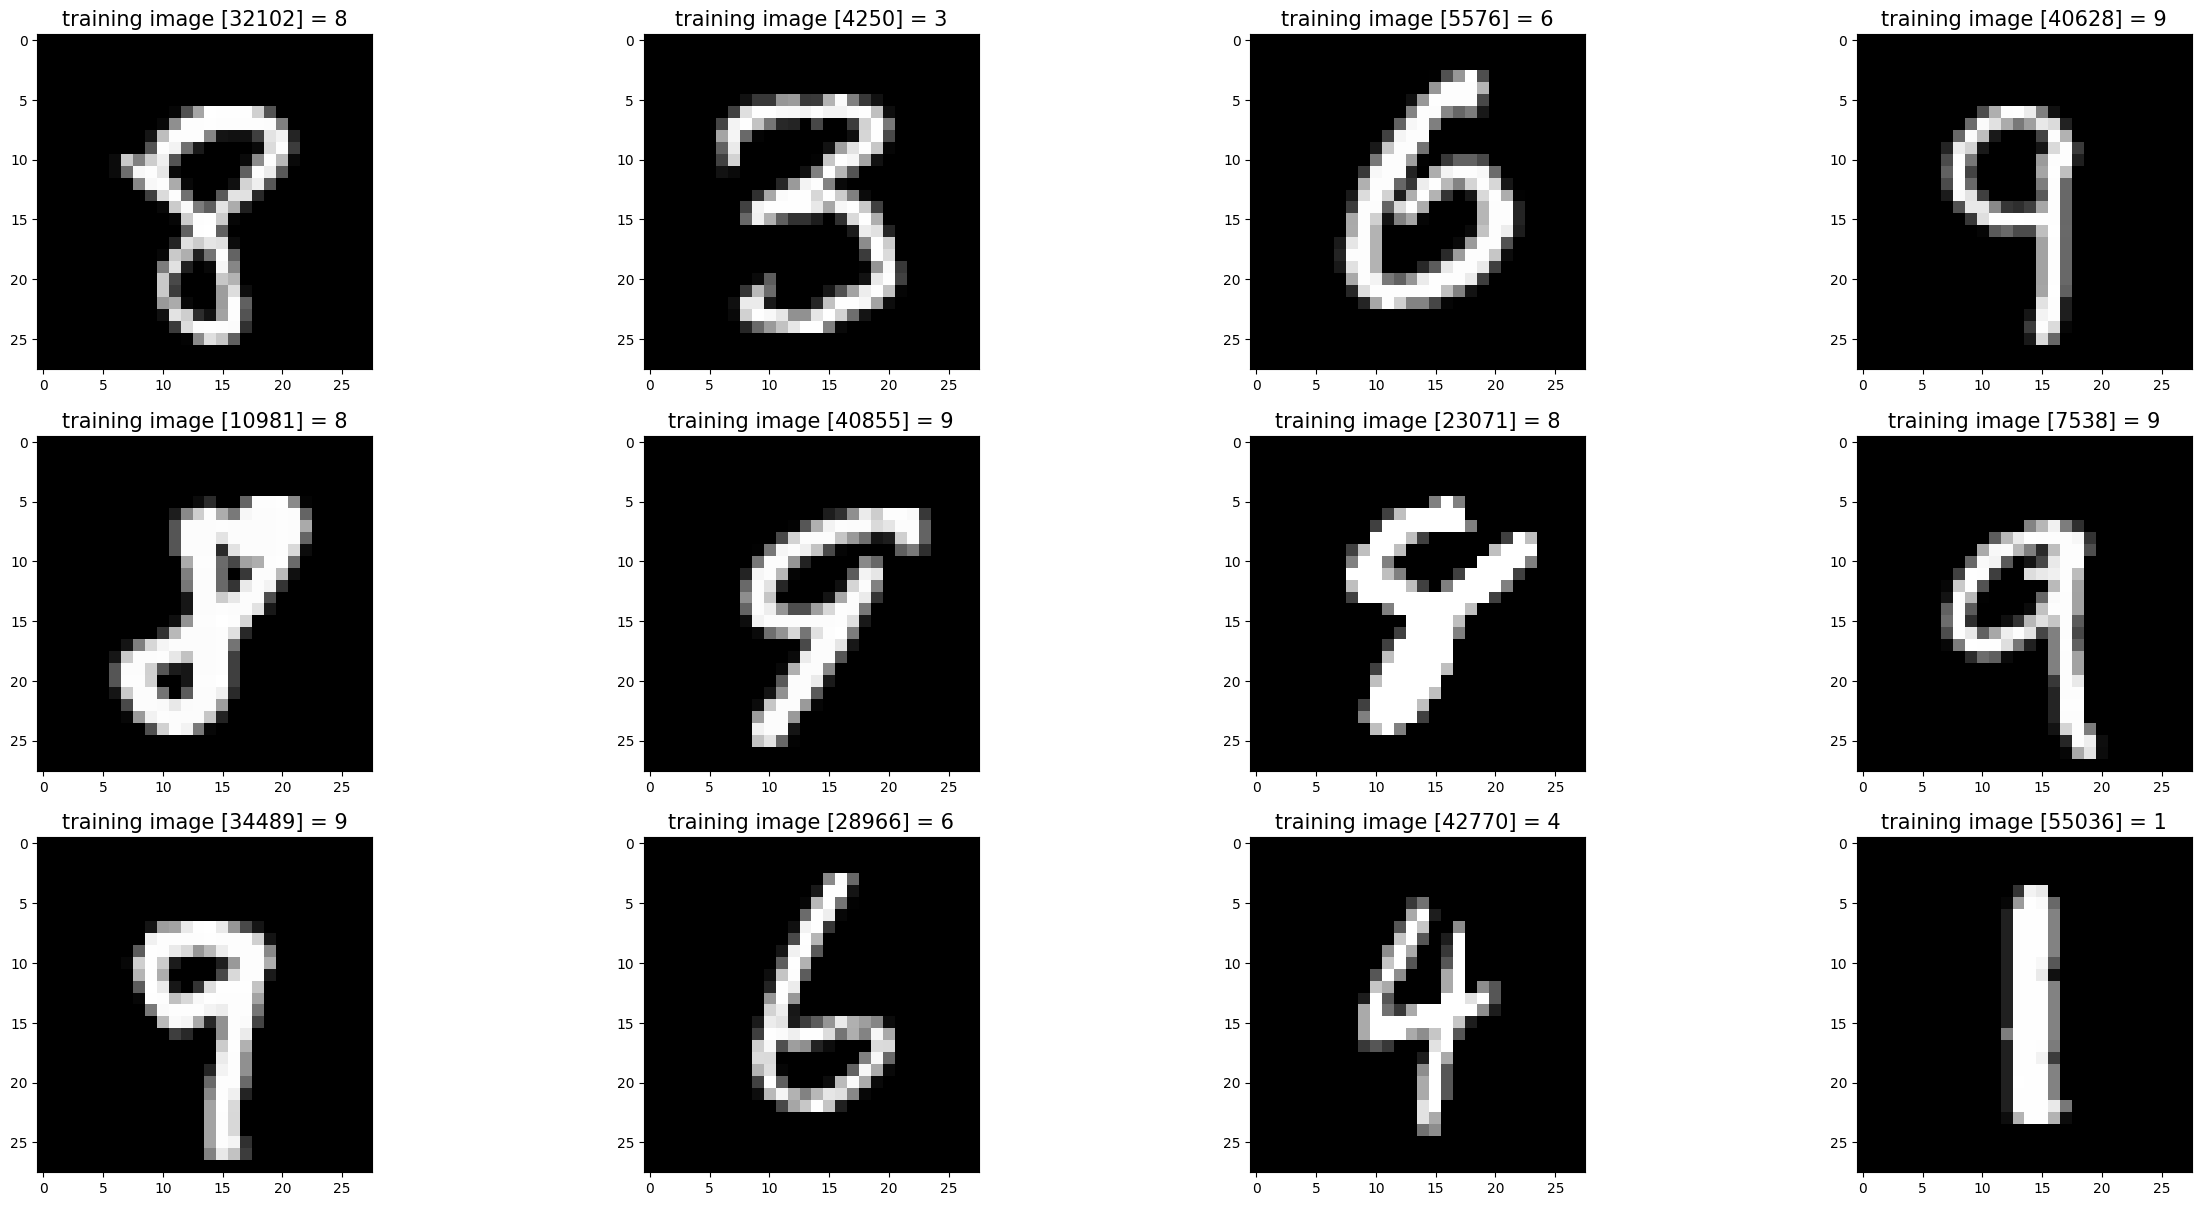

In [6]:
images_to_show = []
titles_to_show = []
for i in range(0, 12):
    r = random.randint(0, len(X_train))
    images_to_show.append(X_train[r])
    titles_to_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

show_images(images_to_show, titles_to_show, 4)

Визуализация случайных 12 изображений в тестовой выборке

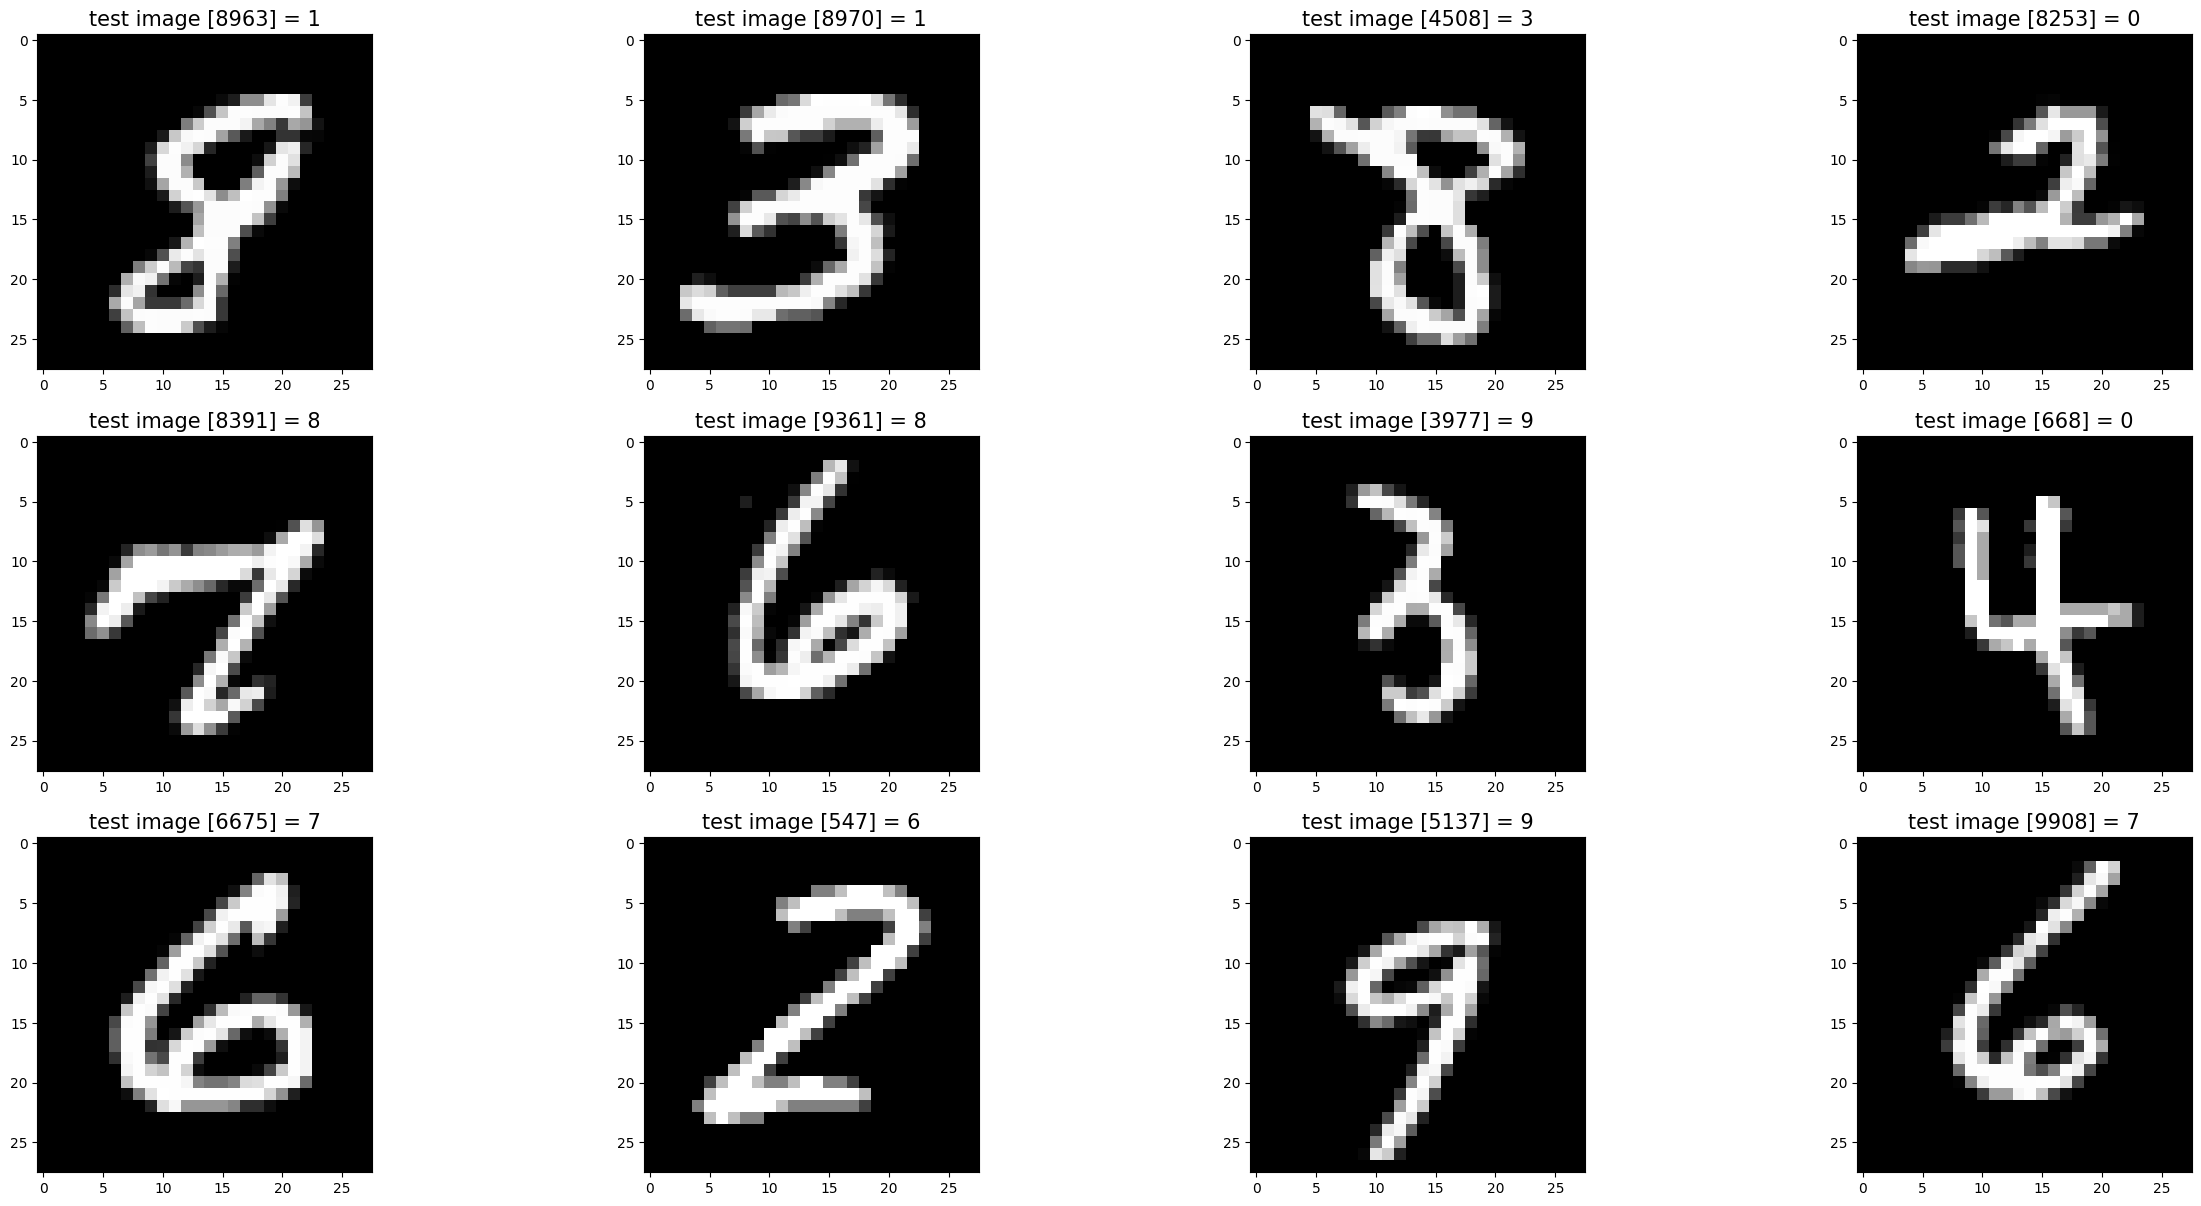

In [7]:
images_to_show = []
titles_to_show = []
for i in range(0, 12):
    r = random.randint(0, len(X_test))
    images_to_show.append(X_test[r])
    titles_to_show.append('test image [' + str(r) + '] = ' + str(y_train[r]))

show_images(images_to_show, titles_to_show, 4)

### Нормализация данных

In [8]:
X_train = np.array(X_train, dtype=np.float32) / 255.0
X_test = np.array(X_test, dtype=np.float32) / 255.0

### One-hot encoding для целевого признака

In [9]:
n_classes = len(np.unique(y_train))
y_train = np.eye(n_classes)[y_train]
y_test = np.eye(n_classes)[y_test]

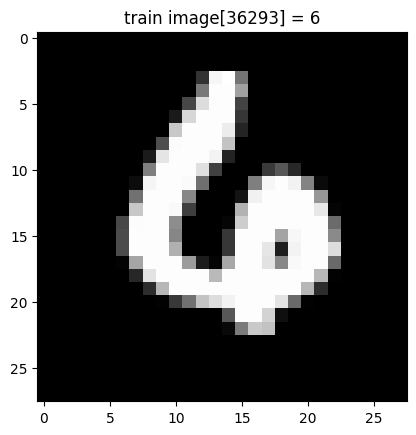

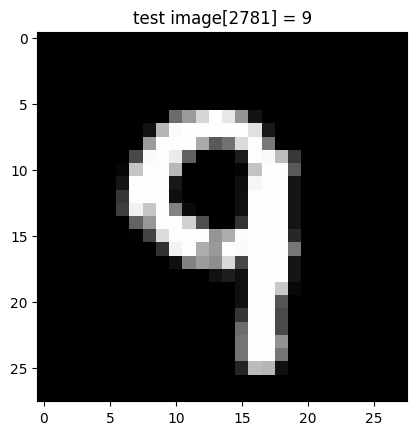

In [10]:
def show_image_norm(X, y, idx, title_text):
    img = X[idx].reshape(28, 28)
    plt.imshow(img, cmap="gray")
    plt.title(f"{title_text} image[{idx}] = {np.argmax(y[idx])}")
    plt.show()
    
show_image_norm(X_train, y_train, random.randint(0, len(X_train)), "train")
show_image_norm(X_test, y_test, random.randint(0, len(X_test)), "test")

### Реализация нейронной сети

Вспомогательные функции для реализации

In [11]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return expZ / expZ.sum(axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

Реализация модели

In [12]:
class Model:
    def __init__(self, input_size: int, output_size: int, hidden_layer_size: int, learning_rate : float):
        self.W1 = np.random.random((input_size, hidden_layer_size)) * math.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_layer_size))
        self.W2 = np.random.random((hidden_layer_size, output_size)) * math.sqrt(2.0 / hidden_layer_size)
        self.b2 =  np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.train_flag = True

    def eval(self):
        self.train_flag = False
    
    def train(self):
        self.train_flag = True

    def zero_grad(self):
        self.Z1 = None
        self.A1 = None
        self.Z2 = None
        self.A2 = None

    def forward(self, images): 
        Z1 = images.dot(self.W1) + self.b1
        A1 = relu(Z1)
        Z2 = A1.dot(self.W2) + self.b2
        A2 = softmax(Z2)
        if self.train_flag:
            self.Z1 = Z1
            self.A1 = A1
            self.Z2 = Z2
            self.A2 = A2
        return A2
    
    def backward(self, X, y_true, learning_rate=0.1):
        m = y_true.shape[0]
        
        dZ2 = self.A2 - y_true
        dW2 = (self.A1.T).dot(dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = dZ2.dot(self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = (X.T).dot(dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        self.__update_weights(dW1, db1, dW2, db2)

    def __update_weights(self, dW1, db1, dW2, db2):
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def __call__(self, X, y = []):
        output = self.forward(X)
        if self.train_flag:
            self.backward(X, y, self.learning_rate)
        return output


### Обучение модели

In [13]:
INPUT_SIZE = 784  # 28x28 pixels
HIDDEN_SIZE = 300
OUTPUT_SIZE = 10
LEARNING_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 20

model = Model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, learning_rate=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    # Случайное перемешивание тренировочных данных
    permutation = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[permutation]
    y_train_shuffled = y_train[permutation]

    losses = []
    start_time = time()
    for i in range(0, X_train.shape[0], BATCH_SIZE):
        X_batch = X_train_shuffled[i:i+BATCH_SIZE]
        y_batch = y_train_shuffled[i:i+BATCH_SIZE]
        model.zero_grad()
        output = model(X_batch, y_batch)
        losses.append(cross_entropy_loss(output, y_batch))
    
    end_time = time()
    
    model.eval()
    train_output = model(X_train)
    train_accuracy = np.mean(np.argmax(train_output, axis=1) == np.argmax(y_train, axis=1))
    
    test_output = model(X_test)
    test_accuracy = np.mean(np.argmax(test_output, axis=1) == np.argmax(y_test, axis=1))
    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}],", 
        f"Time: {end_time - start_time:.2f} secodns,",
        f"Loss mean: {np.mean(losses):.4f},", 
        f"Train accurancy: {train_accuracy * 100:.2f}%,",
        f"Test accuracy: {test_accuracy * 100:.2f}%"
    )
    model.train()


Epoch [1/20], Time: 6.33 secodns, Loss mean: 4.2858, Train accurancy: 94.15%, Test accuracy: 93.99%
Epoch [2/20], Time: 6.39 secodns, Loss mean: 1.8889, Train accurancy: 96.13%, Test accuracy: 95.67%
Epoch [3/20], Time: 5.60 secodns, Loss mean: 1.4119, Train accurancy: 97.16%, Test accuracy: 96.48%
Epoch [4/20], Time: 5.65 secodns, Loss mean: 1.1386, Train accurancy: 97.41%, Test accuracy: 96.63%
Epoch [5/20], Time: 5.86 secodns, Loss mean: 0.9687, Train accurancy: 97.94%, Test accuracy: 97.00%
Epoch [6/20], Time: 5.64 secodns, Loss mean: 0.8459, Train accurancy: 98.26%, Test accuracy: 97.25%
Epoch [7/20], Time: 5.75 secodns, Loss mean: 0.7466, Train accurancy: 98.33%, Test accuracy: 97.23%
Epoch [8/20], Time: 5.69 secodns, Loss mean: 0.6699, Train accurancy: 98.64%, Test accuracy: 97.50%
Epoch [9/20], Time: 5.80 secodns, Loss mean: 0.6106, Train accurancy: 98.86%, Test accuracy: 97.64%
Epoch [10/20], Time: 5.77 secodns, Loss mean: 0.5422, Train accurancy: 98.98%, Test accuracy: 97.68%